# Introduction à Langgraph 



In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import add
import time
# STATE 
# Définition du state du graphe.
# Il s'agit d'un dictionnaire typé qui sera partagé entre les différents noeuds du graphe.
# Il est important de noter que le state est mutable et peut être modifié par les noeuds.
class State(TypedDict):
    """
    Définition du state du graphe.
    Partagé entre les différents noeuds (steps) du graphe.
    Potentiellenemt mise-à-jour par les noeuds.
    """
    input: str
    some_logs: Annotated[list[str], add] # Lorsque les clés sont mise-à-jour par différents noeuds, il est nécessaire de définir un type d'agrégation.
    some_intermediate_value: int
    output: str

# NODES
# Définition des noeuds du graphe.
# Chaque noeud est une fonction qui prend en entrée le state, réalise un traitement et met potientiellement le state à jour.
async def node1(state: State):
    log = f"log from node 1: done something with input: {state["input"]}"
    time.sleep(2)
    return {"some_logs": [log], "some_intermediate_value": 42}

async def node2(state: State):
    log = f"log from node 2: done another thing with node 1 output: {state["some_intermediate_value"]}"
    time.sleep(10)
    response = f"The final answser to the ultimate question of life, the universe, and everything is clearly {state["some_intermediate_value"]}."
    return {"some_logs": [log], "output": response}


# GRAPH
# Création du graphe d'état.
# 1. On crée une instance de StateGraph avec le type State.
# 2. On ajoute les noeuds au graphe avec des noms descriptifs.
# 3. On ajoute les arêtes entre les noeuds pour définir le flux d'exécution.
# 4. On compile le graphe pour le rendre prêt à l'emploi.
graph_builder = StateGraph(State)

graph_builder.add_node("Do something", node1)
graph_builder.add_node("Then another thing", node2)


graph_builder.add_edge(START, "Do something")
graph_builder.add_edge("Do something", "Then another thing")
graph_builder.add_edge("Then another thing", END)

graph = graph_builder.compile()

### Graph vizualisation

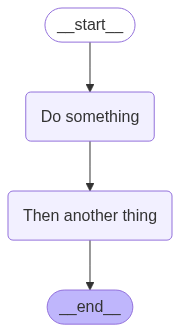

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Graph execution

In [3]:
output = await graph.ainvoke({"input": "Quelle est la réponse à la grand question de la vie, de l'univers et de tout le reste ?",})
output

{'input': "Quelle est la réponse à la grand question de la vie, de l'univers et de tout le reste ?",
 'some_logs': ["log from node 1: done something with input: Quelle est la réponse à la grand question de la vie, de l'univers et de tout le reste ?",
  'log from node 2: done another thing with node 1 output: 42'],
 'some_intermediate_value': 42,
 'output': 'The final answser to the ultimate question of life, the universe, and everything is clearly 42.'}

### Conditions

Langgraph permet de router entre plusieurs noeuds sous condition en utilisant `add_conditional_edges`

Exemple de cas concret : Analyse de contenu selon type détecté

* Node 1 : Détecte le type de document (mail ou note).
* Condition : Route selon le type.
* Node 2a : Résume un email.
* Node 2b : Résume une note.

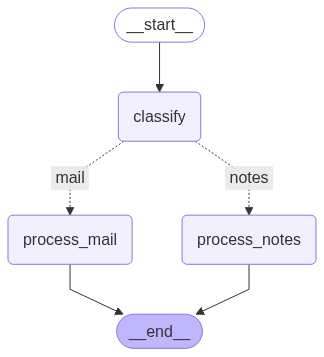

In [4]:
import random
from typing import Literal

class StateCondition(TypedDict):
    input: str
    typology: Literal['mail', 'notes']
    output: str

# NODES
async def classify(state: StateCondition):
    # Simuler une classification par un LLM
    return {"typology": random.choice(['mail', 'notes'])}

async def process_mail(state: StateCondition):
    return {"output": "Mail has been processed"}

async def process_notes(state: StateCondition):
    return {"output": "Notes has been processed"}

def route_process(state: StateCondition) -> str:
    return state["typology"]

# GRAPH
graph_builder = StateGraph(StateCondition)

graph_builder.add_node(classify)
graph_builder.add_node(process_mail)
graph_builder.add_node(process_notes)

graph_builder.add_edge(START, "classify")
graph_builder.add_conditional_edges("classify",route_process, {"mail": "process_mail", "notes": "process_notes"})

conditional_graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(conditional_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
output = await conditional_graph.ainvoke({"input": "some input",})
output

{'input': 'some input',
 'typology': 'mail',
 'output': 'Mail has been processed'}

### Parallélisation

#### Statique

L'exécution des nodes d'un grpahe peut être très facilement parallélisé lors de la déclaration des edges.

Cas concret : Préparer deux résumés indépendants

* Node 1 : Produit un contenu long.
* Node 2a : Génère un résumé pour expert.
* Node 2b : Génère un résumé pour novice.

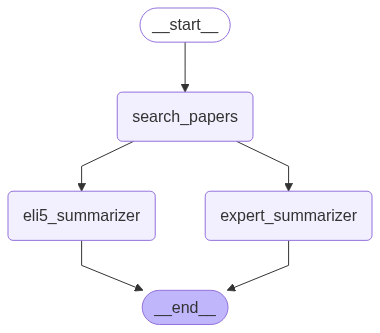

{'input': 'LLM',
 'search_result': 'Large Language Models (LLMs) have demonstrated impressive capabilities in a wide range of natural language processing tasks. Recent work has shown that their performance can be further improved via techniques like few-shot prompting and instruction tuning. However, concerns remain about their reliability, interpretability, and the ethical implications of their large-scale deployment.',
 'expert_output': 'LLMs atteignent des performances remarquables en NLP, renforcées par des méthodes comme le few-shot et l’instruction tuning. Des préoccupations persistent quant à leur fiabilité, leur transparence et les enjeux éthiques liés à leur déploiement à grande échelle.',
 'eli5_output': 'Ces gros modèles d’IA sont très doués pour comprendre et écrire du texte. On peut les améliorer en leur donnant des exemples ou des consignes, mais ils font encore parfois des erreurs et peuvent poser des problèmes qu’il faut surveiller.'}

In [ ]:
class StateParallelStatic(TypedDict):
    input: str
    search_result: str
    expert_output: str
    eli5_output: str

# NODES
async def search_papers(state: StateParallelStatic):
    search_result = "Large Language Models (LLMs) have demonstrated impressive capabilities in a wide range of natural language processing tasks. Recent work has shown that their performance can be further improved via techniques like few-shot prompting and instruction tuning. However, concerns remain about their reliability, interpretability, and the ethical implications of their large-scale deployment."
    return {"search_result": search_result}

async def expert_summarizer(state: StateCondition):
    output = """LLMs atteignent des performances remarquables en NLP, renforcées par des méthodes comme le few-shot et l’instruction tuning. Des préoccupations persistent quant à leur fiabilité, leur transparence et les enjeux éthiques liés à leur déploiement à grande échelle."""
    return {"expert_output": output}

async def eli5_summarizer(state: StateCondition):
    output = "Ces gros modèles d’IA sont très doués pour comprendre et écrire du texte. On peut les améliorer en leur donnant des exemples ou des consignes, mais ils font encore parfois des erreurs et peuvent poser des problèmes qu’il faut surveiller."
    return {"eli5_output": output}


# GRAPH
graph_builder = StateGraph(StateParallelStatic)

graph_builder.add_node(search_papers)
graph_builder.add_node(expert_summarizer)
graph_builder.add_node(eli5_summarizer)

graph_builder.add_edge(START, "search_papers")
graph_builder.add_edge("search_papers", "expert_summarizer")
graph_builder.add_edge("search_papers", "eli5_summarizer")

parallel1_graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(parallel1_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

output = await parallel1_graph.ainvoke({"input": "LLM",})
output

#### Dynamique

Dans certains cas, on peut avoir besoin de paralléliser la même tâche, sans savoir à l'avance le nombre de tâche. 

Cas concret : Génération de plusieurs blagues sur des sujets dynamiques

* Node 1 : Génère une liste de n sujets à partir d’un thème (ex : “bureau”).
* Router : Crée un branchement dynamique pour chaque sujet.
* Node 2a/b/c... : Génère une blague sur chaque sujet.
* Node 3 : Sélectionne la meilleure blague.

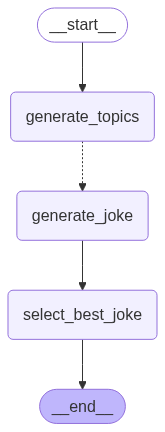

{'contraints': 'An inoffensive joke, suitable for a 5 years old',
 'topics': ['lions', 'elephants', 'penguins'],
 'jokes': ["Why don't lions like fast food? Because they can't catch it!",
  "Why don't elephants use computers? They're afraid of the mouse!",
  'Why don’t penguins like talking to strangers at parties? Because they find it hard to break the ice.'],
 'best_joke': "Why don't elephants use computers? They're afraid of the mouse!"}

In [14]:
import random
from langgraph.types import Send

class StateDynamicParallel(TypedDict):
    contraints: str
    topics: list[str]
    jokes: Annotated[list[str], add]
    best_joke: str

class JokeState(TypedDict):
    topic: str

# NODES
async def generate_topics(state: StateDynamicParallel):
    # Simuler l'appel à un LLM pour générer des sujets aléatoires
    return {"topics": ["lions", "elephants", "penguins"]}
    
async def generate_joke(state: JokeState):
    # Simuler l'appel à un LLM pour générer un blague sur un sujet donné
    joke_map = {
        "lions": "Why don't lions like fast food? Because they can't catch it!",
        "elephants": "Why don't elephants use computers? They're afraid of the mouse!",
        "penguins": (
            "Why don’t penguins like talking to strangers at parties? "
            "Because they find it hard to break the ice."
        ),
    }
    return {"jokes": [joke_map[state["topic"]]]}

async def select_best_joke(state: StateDynamicParallel):
    # Simuler le choix par un LLM de la meilleure blague parmi celles générées
    selected = random.choice(state["jokes"]) if state["jokes"] else []
    return {"best_joke": selected}

def parallelize(state: StateDynamicParallel):
    # Return a list of Send actions to invoke node2 in parallel
    return [Send("generate_joke", {"topic": topic}) for topic in state["topics"]]


# GRAPH
graph_builder = StateGraph(StateDynamicParallel)

graph_builder.add_node(generate_topics)
graph_builder.add_node(generate_joke)
graph_builder.add_node(select_best_joke)

graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges("generate_topics",parallelize, ["generate_joke"])
graph_builder.add_edge("generate_joke", "select_best_joke")
joke_graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(joke_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

output = await joke_graph.ainvoke({"contraints": "An inoffensive joke, suitable for a 5 years old",})
output

### Boucle de contrôle

L'utilisation de condition pour le routage permet de facilement en place une boucle de generation<->feedback

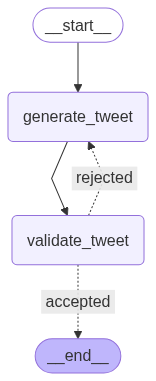

{'input': 'chatbots dans l’éducation',
 'proposals': ['Les chatbots révolutionnent l’éducation comme jamais auparavant. C’est tout simplement incroyable\u202f!',
  "Grâce aux avancées technologiques incroyables de l’IA, notamment les modèles de type GPT-4, les environnements éducatifs peuvent désormais être transformés en hubs intelligents favorisant l'apprentissage adaptatif en continu, tout en réduisant la charge cognitive des enseignants.",
  'Les chatbots aident les étudiants à réviser à toute heure. Une nouvelle ère pour l’éducation personnalisée.'],
 'feedbacks': [{'status': 'rejected',
   'feedbacks': 'Utilisation de termes vagues et superlatifs : révolutionnent, incroyable.  Recommander un ton plus neutre et informatif.'},
  {'status': 'rejected',
   'feedbacks': 'Trop long : dépasse largement la limite des 280 caractères. Suggérer de résumer l’idée en deux phrases courtes, focalisées sur un seul point.'},
  {'status': 'accepted',
   'feedbacks': 'Le tweet est clair, factuel et

In [15]:
from operator import add
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict

class StateControlFlow(TypedDict):
    input: str
    proposals: Annotated[list[str], add]
    feedbacks: Annotated[list[dict], add]

# NODES
async def generate_tweet(state: StateControlFlow):
    # Simuler l'appel à un LLM pour générer des sujets aléatoires
    tweets = [
        "Les chatbots révolutionnent l’éducation comme jamais auparavant. C’est tout simplement incroyable !",
        "Grâce aux avancées technologiques incroyables de l’IA, notamment les modèles de type GPT-4, les environnements éducatifs peuvent désormais être transformés en hubs intelligents favorisant l'apprentissage adaptatif en continu, tout en réduisant la charge cognitive des enseignants.""",
        "Les chatbots aident les étudiants à réviser à toute heure. Une nouvelle ère pour l’éducation personnalisée."
    ]
    return {"proposals": [tweets[len(state["proposals"])]]}
    
async def validate_tweet(state: StateControlFlow):
    # Simuler l'appel à un LLM pour générer un blague sur un sujet donné
    feedbacks = [
        {"status": "rejected", "feedbacks": "Utilisation de termes vagues et superlatifs : révolutionnent, incroyable.  Recommander un ton plus neutre et informatif."},
    {"status": "rejected", "feedbacks": "Trop long : dépasse largement la limite des 280 caractères. Suggérer de résumer l’idée en deux phrases courtes, focalisées sur un seul point."},
    {"status": "accepted", "feedbacks": "Le tweet est clair, factuel et tient en deux phrases. Pas de langage excessif ni de mot vide de sens."},
     ]
    return {"feedbacks": [feedbacks[len(state["feedbacks"])]]}

async def control_router(state: StateControlFlow):
    # Simuler le choix par un LLM de la meilleure blague parmi celles générées
    return  state["feedbacks"][len(state["feedbacks"]) - 1]["status"]


# GRAPH
graph_builder = StateGraph(StateControlFlow)

graph_builder.add_node(generate_tweet)
graph_builder.add_node(validate_tweet)

graph_builder.add_edge(START, "generate_tweet")

graph_builder.add_edge("generate_tweet", "validate_tweet")
graph_builder.add_conditional_edges("validate_tweet",control_router, {"accepted": END, "rejected": "generate_tweet"})
graph_builder = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph_builder.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

output = await graph_builder.ainvoke({"input": "chatbots dans l’éducation",})
output

### Invocation vs streaming

Dès qu'un agent/workflow devient un peu complexe son temps d'exécution et sa transparence se dégradent fortement.

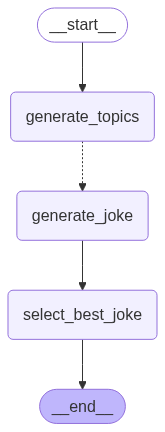

In [16]:
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel


class GeneratedTopics(BaseModel):
    topics: list[str]

class StreamingState(TypedDict):
    contraints: str
    topics: list[str]
    jokes: Annotated[list[str], add]
    best_joke: str

class JokeState(TypedDict):
    topic: str
    contraints: str

# NODES
async def generate_topics(state: StreamingState):
    model = ChatOpenAI(model="gpt-4o-mini").with_structured_output(GeneratedTopics)
    response = PromptTemplate.from_template(
        "Generate a list of 3 random one word topics for jokes suitable for theses given constraint. Do not generate the jokes only the topics.\n"
        "Here are the constraints: {input}."
    ).pipe(model).invoke({"input": state["contraints"]})
    return {"topics": GeneratedTopics.model_validate(response).topics}
    
async def generate_joke(state: JokeState):
    model = ChatOpenAI(model="gpt-4o-mini")
    response = PromptTemplate.from_template(
        "Generate a short joke about {topic} that is suitable for theses given constraint: {contraints}."
    ).pipe(model).invoke({"topic": state["topic"], "contraints": state["contraints"]})
    return {"jokes": [response.content]}

async def select_best_joke(state: StreamingState):
    model = ChatOpenAI(model="gpt-4o-mini")
    response = PromptTemplate.from_template(
        "Here are three jokes, select the most appropriate one for theses given constraint: {contraints}.\n. Your response must be only the selected joke, nothing else.\n Here are the jokes:\n{jokes}\n"
    ).pipe(model).invoke({"jokes": "\n".join(state["jokes"]), "contraints": state["contraints"]})
    return {"best_joke": response.content}

def parallelize(state: StreamingState):
    # Return a list of Send actions to invoke node2 in parallel
    return [Send("generate_joke", {"topic": topic, "contraints": state["contraints"]}) for topic in state["topics"]]


# GRAPH
graph_builder = StateGraph(StreamingState)

graph_builder.add_node(generate_topics)
graph_builder.add_node(generate_joke)
graph_builder.add_node(select_best_joke)

graph_builder.add_edge(START, "generate_topics")
graph_builder.add_conditional_edges("generate_topics",parallelize, ["generate_joke"])
graph_builder.add_edge("generate_joke", "select_best_joke")
joke_graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(joke_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [17]:
output = await joke_graph.ainvoke({"contraints": "An inoffensive joke about animals, suitable for a young kid",})
output

{'contraints': 'An inoffensive joke about animals, suitable for a young kid',
 'topics': ['Puppy', 'Kangaroo', 'Goldfish'],
 'jokes': ['Why did the puppy sit in the shade?  \nBecause he didn’t want to become a hot dog!',
  'Why did the kangaroo stop carrying a backpack? \n\nBecause it already had a pouch for its stuff!',
  'Why did the goldfish get a job?  \nBecause it wanted to be a little more “fin”-ancially independent!'],
 'best_joke': 'Why did the puppy sit in the shade?  \nBecause he didn’t want to become a hot dog!'}

#### Stream l'update du state

Mode par défaut = updates = stream les update du state après chaque node

In [18]:
async for chunk in joke_graph.astream(
    {"contraints": "Offensive jokes, borderline inappropriate, but not crossing the line"},
    stream_mode="updates",
):
    print(chunk)

{'generate_topics': {'topics': ['Caffeine', 'Dating', 'Pet']}}
{'generate_joke': {'jokes': ['Why did the coffee file a police report? It got mugged but didn’t espresso its feelings!']}}
{'generate_joke': {'jokes': ['Why did the skeleton go on a dating app? \n\nHe just couldn\'t find "the one" who had the guts!']}}
{'generate_joke': {'jokes': ['Why did the cat sit on the computer?\n\nBecause it wanted to keep an eye on the mouse!']}}
{'select_best_joke': {'best_joke': 'Why did the skeleton go on a dating app? He just couldn\'t find "the one" who had the guts!'}}


Mode = values = The state complet est streamé après chaque node

In [19]:
async for chunk in joke_graph.astream(
    {"contraints": "Offensive jokes, borderline inappropriate, but not crossing the line"},
    stream_mode="values",
):
    print(chunk)

{'contraints': 'Offensive jokes, borderline inappropriate, but not crossing the line', 'jokes': []}
{'contraints': 'Offensive jokes, borderline inappropriate, but not crossing the line', 'topics': ['Awkward', 'Dating', 'Pets'], 'jokes': []}
{'contraints': 'Offensive jokes, borderline inappropriate, but not crossing the line', 'topics': ['Awkward', 'Dating', 'Pets'], 'jokes': ["Why did the awkward person bring a ladder to the bar? Because they heard the drinks were on the house, but didn't know how to ask for a lift!", 'Why did the skeleton break up with his girlfriend?  \n\nHe just didn’t have the guts for a serious relationship!', 'Why did the dog sit in the shade? \n\nBecause it didn’t want to become a hot dog!']}
{'contraints': 'Offensive jokes, borderline inappropriate, but not crossing the line', 'topics': ['Awkward', 'Dating', 'Pets'], 'jokes': ["Why did the awkward person bring a ladder to the bar? Because they heard the drinks were on the house, but didn't know how to ask for a

Mode = messages = token et metadata de tout node contenant une invocation de LLM

In [20]:
async for chunk in joke_graph.astream(
    {"contraints": "Offensive jokes, borderline inappropriate, but not crossing the line"},
    stream_mode="messages",
):
    print(chunk)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--585a4203-aaa1-4516-a76a-85c27e0074ba'), {'langgraph_step': 1, 'langgraph_node': 'generate_topics', 'langgraph_triggers': ('branch:to:generate_topics',), 'langgraph_path': ('__pregel_pull', 'generate_topics'), 'langgraph_checkpoint_ns': 'generate_topics:e37099c8-4258-38dc-8e32-5653f9fed825', 'checkpoint_ns': 'generate_topics:e37099c8-4258-38dc-8e32-5653f9fed825', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature': None})
(AIMessageChunk(content='{"', additional_kwargs={}, response_metadata={}, id='run--585a4203-aaa1-4516-a76a-85c27e0074ba'), {'langgraph_step': 1, 'langgraph_node': 'generate_topics', 'langgraph_triggers': ('branch:to:generate_topics',), 'langgraph_path': ('__pregel_pull', 'generate_topics'), 'langgraph_checkpoint_ns': 'generate_topics:e37099c8-4258-38dc-8e32-5653f9fed825', 'checkpoint_ns': 'generate_topics:e37099c8-4258-38dc-8e32-5653f9fed825',

Le meilleur des mondes, streamer plusieurs mode

In [29]:
from langchain_core.messages import AIMessageChunk

async for mode, chunk in joke_graph.astream({"contraints": "Jokes about IA, suitable for IT guys"}, stream_mode=["updates", "messages"]):

    if (mode == "messages" ):
        msg, metadata = chunk
        if (msg and isinstance(msg, AIMessageChunk) and metadata["langgraph_node"] == "select_best_joke"):
            print(msg.content)
    elif (mode == "updates"):
        print(chunk)

{'generate_topics': {'topics': ['Nerds', 'Algorithms', 'Code']}}
{'generate_joke': {'jokes': ['Why did the nerd bring a ladder to the IT conference?\n\nBecause they heard the cloud was on a higher level!']}}
{'generate_joke': {'jokes': ['Why did the algorithm break up with its partner?  \n\nBecause it couldn\'t find the right "function" in the relationship!']}}
{'generate_joke': {'jokes': ["Why did the AI go broke?\n\nBecause it couldn't find its cache!"]}}

Why
 did
 the
 algorithm
 break
 up
 with
 its
 partner
?
  


Because
 it
 couldn't
 find
 the
 right
 "
function
"
 in
 the
 relationship
!

{'select_best_joke': {'best_joke': 'Why did the algorithm break up with its partner?  \n\nBecause it couldn\'t find the right "function" in the relationship!'}}
